#  **Loading the dataset and importing all the necessary packages**

In [1]:
import numpy as np  
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [2]:
train_data_dir = "../input/chest-xray-pneumonia/chest_xray/train"
val_data_dir = "../input/chest-xray-pneumonia/chest_xray/val"
test_data_dir = "../input/chest-xray-pneumonia/chest_xray/test"


# **Exploratory Data Analysis**

In [3]:
# Setting up folders for normal cases and pneumonia cases wihtin our train data
train_n = train_data_dir + '/NORMAL/'
train_p = train_data_dir + '/PNEUMONIA/'

Normal X-Rays From Validation Set: 1341 
Pneumonia X-Rays From Validation Set: 3875 


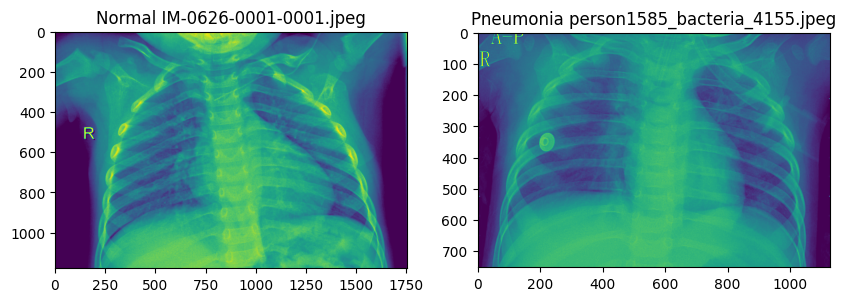

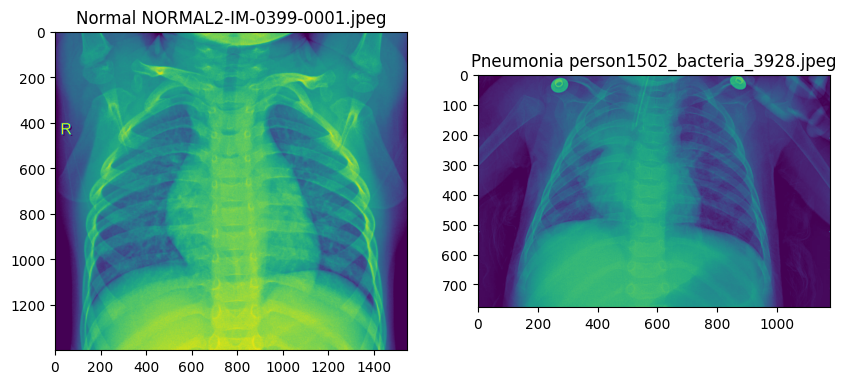

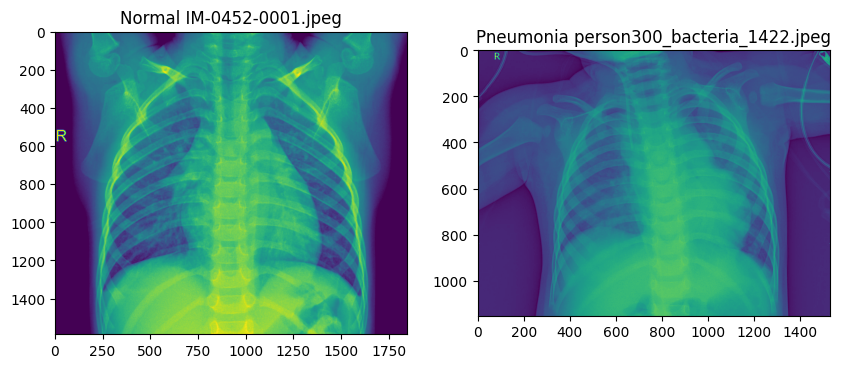

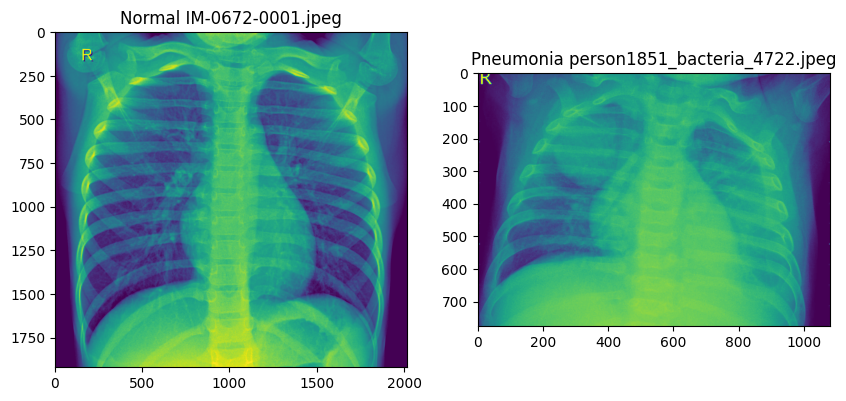

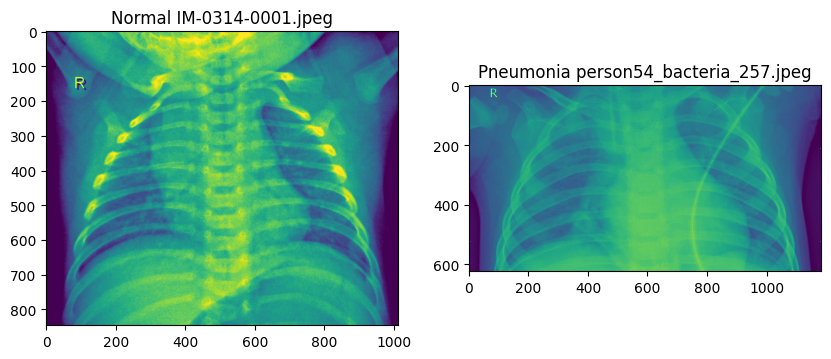

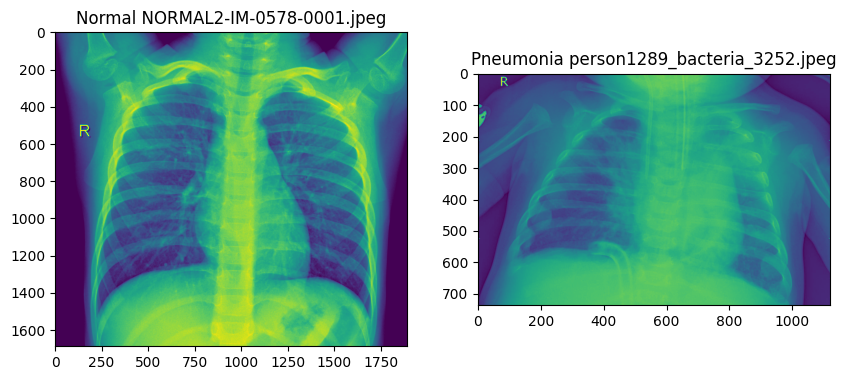

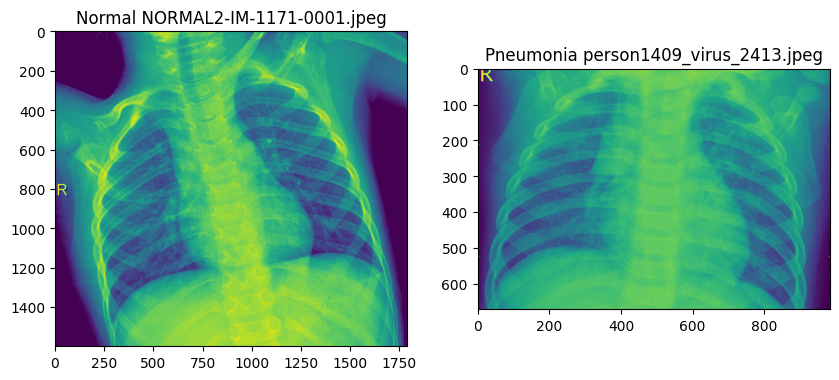

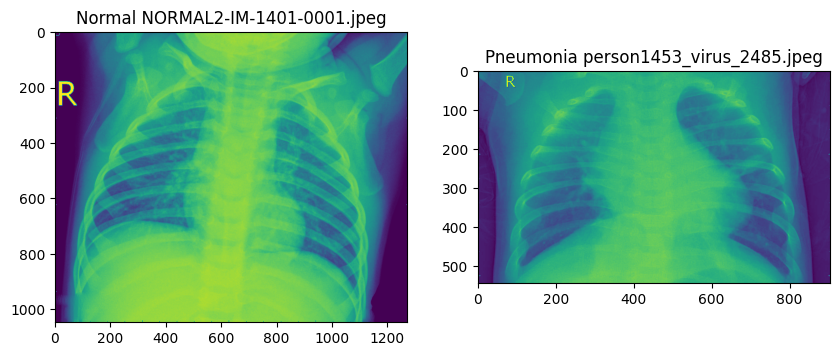

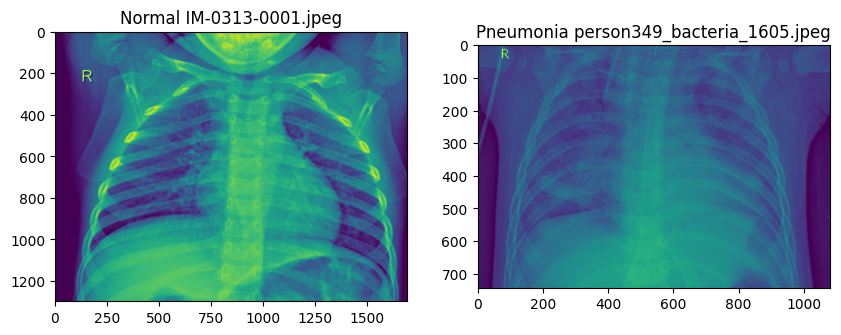

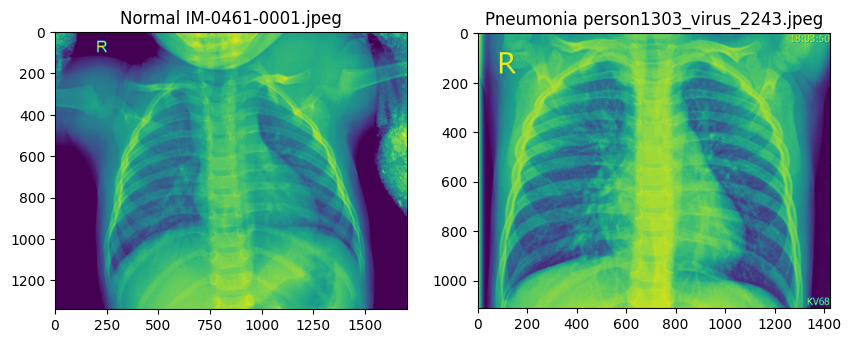

In [4]:
# Random normal picture from train set
print(f"Normal X-Rays From Validation Set: {len(os.listdir(train_n))} ")

# Selecting 10 normal pictures
norm_pic = os.listdir(train_n)[25:35]
norm_pic_address = [train_n + pic for pic in norm_pic]

# Random Pneumonia picture from train set
print(f"Pneumonia X-Rays From Validation Set: {len(os.listdir(train_p))} ")

# Selecting 10 Pneumonia pictures
pneumonia_pic =  os.listdir(train_p)[40:50]
pneumonia_address = [train_p + pic for pic in pneumonia_pic]

for i in range(0,10):
    # Loading the images
    norm_img = Image.open(norm_pic_address[i])
    pneumonia_img = Image.open(pneumonia_address[i])

    #Plotting these images
    
    ## plotting normal picture
    f = plt.figure(figsize= (10,6))
    a1 = f.add_subplot(1,2,1)
    img_plot = plt.imshow(norm_img)
    a1.set_title(f'Normal {norm_pic[i]}')

    ## plotting pneumonia picture
    a2 = f.add_subplot(1, 2, 2)
    img_plot = plt.imshow(pneumonia_img)
    a2.set_title(f'Pneumonia {pneumonia_pic[i]}')

# **Preparing the model**

**Preparing the data**

In [5]:
#  Creating a data augmentor
data_augmentor = ImageDataGenerator(samplewise_center=True, rescale=1./255, shear_range=0.2,zoom_range = 0.2,samplewise_std_normalization=True,validation_split=0.2) 

# Setting hyperparameters
target_size = (128,128)   
target_dims = (128, 128, 3) # add channel for RGB
n_batch_size = 32 

# Creating datasets
train_generator = data_augmentor.flow_from_directory(train_data_dir,  target_size=target_size, subset='training',batch_size= n_batch_size,class_mode='binary')
val_generator = data_augmentor.flow_from_directory(train_data_dir, target_size=target_size,subset='validation',class_mode='binary')
test_generator = data_augmentor.flow_from_directory(test_data_dir, target_size=target_size,batch_size= 1,class_mode=None, shuffle=False)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**Building the model**

In [6]:
def initialize_model(name):    
    model = Sequential(name=name)
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=target_dims, padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    
    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
        
    model.add(layers.Conv2D(128, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3, 3)))
    model.add(Dropout(0.1))
    
    model.add(layers.Flatten())    
    model.add(layers.Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [7]:
model = initialize_model(name="basemodel")
model.summary()

Model: "basemodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 64)        0 

In [8]:
def compile_model(model):
    model.compile(optimizer="adam",loss='binary_crossentropy',metrics="binary_accuracy")
    return model

**Regularization**

In [9]:
model_baseline = initialize_model(name="baseline")
history_baseline = compile_model(model_baseline)

callback = [EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 2, factor=0.5, verbose=1),
            ModelCheckpoint("xray_model_v2.h5",save_best_only=True)]

# **Training the model**

In [10]:
history_baseline = model_baseline.fit(train_generator,
                                      batch_size=n_batch_size,
                                      epochs=10,
                                      validation_data=val_generator,shuffle=True,
                                      callbacks=callback) #,class_weight=class_weights)

Epoch 1/10
131/131 [==============================] - 135s 1s/step - loss: 0.4221 - binary_accuracy: 0.8121 - val_loss: 0.2486 - val_binary_accuracy: 0.9012 - lr: 0.0010
Epoch 2/10
131/131 [==============================] - 132s 1s/step - loss: 0.2353 - binary_accuracy: 0.9022 - val_loss: 0.2206 - val_binary_accuracy: 0.9032 - lr: 0.0010
Epoch 3/10
131/131 [==============================] - 133s 1s/step - loss: 0.1936 - binary_accuracy: 0.9319 - val_loss: 0.1951 - val_binary_accuracy: 0.9214 - lr: 0.0010
Epoch 4/10
131/131 [==============================] - 132s 1s/step - loss: 0.1754 - binary_accuracy: 0.9367 - val_loss: 0.1589 - val_binary_accuracy: 0.9377 - lr: 0.0010
Epoch 5/10
131/131 [==============================] - 132s 1s/step - loss: 0.1623 - binary_accuracy: 0.9406 - val_loss: 0.1694 - val_binary_accuracy: 0.9252 - lr: 0.0010
Epoch 6/10
131/131 [==============================] - ETA: 0s - loss: 0.1549 - binary_accuracy: 0.9468
Epoch 6: ReduceLROnPlateau reducing learning ra

# **Evaluating the model**

In [11]:
scores = model_baseline.evaluate(val_generator)
scores

33/33 [==============================] - 18s 549ms/step - loss: 0.1217 - binary_accuracy: 0.9501


[0.12172998487949371, 0.9501438140869141]

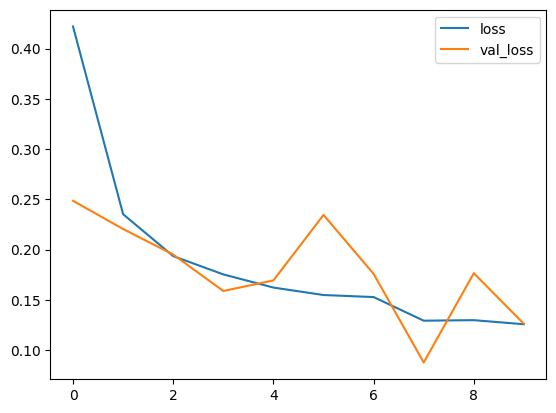

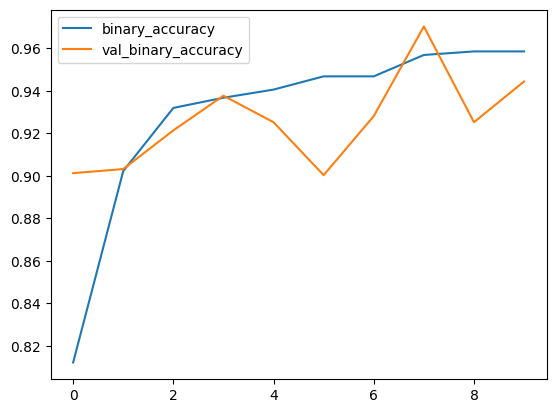

In [12]:
history_frame = pd.DataFrame(history_baseline.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();